# Notebook - Dallas Morning News Case Study

The Dallas Morning News [uncovers a cheating scandal on the TAKS test](http://clipfile.org/?p=754). 

_note: Try not to consult the clip above unless you're stuck. The clip also doesn't contain all of the answers so there is still plenty to investigate._

> You're a reporter at the Dallas Morning News in 2005. While talking to some teachers at your local school district, you recieved a tip that a **fourth grade classroom at Harrell Budd Elementary in southern Dallas has unusually high test scores in reading** on the TAKS test (the state's standardized test to measure student progress). To check out this claim you've downloaded data from the Texas Education Agency. To dig deeper into this, you have acquired records from the district of average standardized TAKS test scores for reading and math for third, fourth and fifth graders for the previous year. You also decide to download the reading scores for 2003.

Let's see how the Dallas Morning News used regressions to find evidence of this claim and try to find out if it is an isolated case.

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **cfy04e4.dat:** 2004 fourth-grade TAKS scores - standardized test scores for 2004's fourth-graders
* **cfy04e5.dat:** 2004 fifth-grade TAKS scores - standardized test scores for 2004's fifth-graders
* **cfy04e3.dat:** 2004 third-grade TAKS scores - standardized test scores for 2004's third-graders

More data you might want
* **cfy03e3.dat:** 2003 third-grade TAKS scores - standardized test scores for 2003's third-graders

Data Documentation: 
https://tea.texas.gov/student-assessment/testing/taks-resources/taks-variables-formats-and-descriptions


In [1]:
pip install wget


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import wget

In [3]:
# # Make data directory if it doesn't exist
# # (you can remove the comments, run this cell once to download the data, and add the comments back)
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e4.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy03e3.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e5.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e3.dat -P data

File ‘data/cfy04e4.dat’ already there; not retrieving.

File ‘data/cfy03e3.dat’ already there; not retrieving.

File ‘data/cfy04e5.dat’ already there; not retrieving.

File ‘data/cfy04e3.dat’ already there; not retrieving.



### R and Python Imports

In [4]:
%reload_ext rpy2.ipython
%reload_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

In [5]:
%%R

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


In [6]:
import pandas as pd
import numpy as np

# Show a large number of rows and columns when displaying dfs
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
from IPython.display import display, HTML

# Finding suspicious datapoints with linear regression

Can we see evidence of possible cheating at Harrell Budd Elementary? Is Harrell Budd Elementary's fourth grade reading classrooms the only place where we see signs of possible cheating in 2004? 

How else can you design regressions to help you uncover other instances of cheating? Let's build a model to find out.

![](residuals.png)


## Load the data 
We'll start by opening up our dataset - standardized test performance at each school. We have:
- 3rd 4th and 5th grade reading and math scores for 2004 
- 4th grade reading and math scores for 2003

In [7]:
df_third_grade_2004 = pd.read_csv("data/cfy04e3.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_third_2004')
df_fourth_grade_2004 = pd.read_csv("data/cfy04e4.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_fourth_2004')
df_fifth_grade_2004 = pd.read_csv("data/cfy04e5.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_fifth_2004')

# This time I'm also adding fourth grade scores from last year (2003)! 
df_third_grade_2003 = pd.read_csv("data/cfy03e3.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_third_2003')

# Display the first 3 rows of each df
display(df_third_grade_2004.head(3))
display(df_fourth_grade_2004.head(3))
display(df_fifth_grade_2004.head(3))
display(df_third_grade_2003.head(3))


,CNAME_third_2004,r_all_rs_third_2004,m_all_rs_third_2004
CAMPUS,,,
1902103,CAYUGA EL,2410.0,2388.0
1903101,ELKHART EL,2256.0,2208.0
1904102,FRANKSTON EL,2284.0,2313.0


,CNAME_fourth_2004,r_all_rs_fourth_2004,m_all_rs_fourth_2004
CAMPUS,,,
1902103,CAYUGA EL,2392.0,2227.0
1903101,ELKHART EL,2263.0,2192.0
1904102,FRANKSTON EL,2242.0,2152.0


,CNAME_fifth_2004,r_all_rs_fifth_2004,m_all_rs_fifth_2004
CAMPUS,,,
1902103,CAYUGA EL,2308.0,2317.0
1903101,ELKHART EL,2193.0,2153.0
1904102,FRANKSTON EL,2288.0,2256.0


,CNAME_third_2003,r_all_rs_third_2003,m_all_rs_third_2003
CAMPUS,,,
1902103,CAYUGA EL,2330.0,2350.0
1903101,ELKHART EL,2285.0,2183.0
1904102,FRANKSTON EL,2299.0,2248.0


## Clean The Data 🧹

In [8]:
# Combine the above dataframes, remove duplicate columns
df = pd.concat([df_third_grade_2004, df_fourth_grade_2004, df_fifth_grade_2004, df_third_grade_2003], axis=1)
df['CNAME'] = df['CNAME_third_2004'].fillna(df['CNAME_fourth_2004']).fillna(df['CNAME_fifth_2004']).fillna(df['CNAME_third_2003'])
df = df.drop(columns=['CNAME_third_2004', 'CNAME_fourth_2004', 'CNAME_fifth_2004', 'CNAME_third_2003'])
df = df.reset_index()

# remove _all_rs from column names
df.columns = df.columns.str.replace('_all_rs', '')

# display
df


,CAMPUS,r_third_2004,m_third_2004,r_fourth_2004,m_fourth_2004,r_fifth_2004,m_fifth_2004,r_third_2003,m_third_2003,CNAME
0,1902103,2410.0,2388.0,2392.0,2227.0,2308.0,2317.0,2330.0,2350.0,CAYUGA EL
1,1903101,2256.0,2208.0,2263.0,2192.0,2193.0,2153.0,2285.0,2183.0,ELKHART EL
2,1904102,2284.0,2313.0,2242.0,2152.0,2288.0,2256.0,2299.0,2248.0,FRANKSTON EL
3,1906102,2294.0,2273.0,2218.0,2096.0,2298.0,2312.0,2236.0,2223.0,NECHES EL
4,1907110,2256.0,2205.0,2200.0,2168.0,2218.0,2269.0,2202.0,2142.0,STORY EL
...,...,...,...,...,...,...,...,...,...,...
4279,221901123,NaN,NaN,NaN,NaN,NaN,NaN,2284.0,2174.0,VALLEY VIEW EL
4280,226906180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRAPE CREEK SPE
4281,227913101,NaN,NaN,NaN,NaN,NaN,NaN,2364.0,2310.0,LAKE TRAVIS EL
4282,233901104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MARION RUSSELL


In [9]:
# Here is the dataframe above in long format if you'd prefer it that way!
df_long = df.melt(id_vars=['CAMPUS', 'CNAME'], var_name='test_type', value_name='score').dropna()
df_long

,CAMPUS,CNAME,test_type,score
0,1902103,CAYUGA EL,r_third_2004,2410.0
1,1903101,ELKHART EL,r_third_2004,2256.0
2,1904102,FRANKSTON EL,r_third_2004,2284.0
3,1906102,NECHES EL,r_third_2004,2294.0
4,1907110,STORY EL,r_third_2004,2256.0
...,...,...,...,...
34264,220908102,ERMA NASH ELEME,m_third_2003,2183.0
34266,221901101,ALTA VISTA EL,m_third_2003,2212.0
34267,221901123,VALLEY VIEW EL,m_third_2003,2174.0
34269,227913101,LAKE TRAVIS EL,m_third_2003,2310.0


# Explore the data

Let's see where `HARRELL BUDD EL` stands in the 2004 fourth grade reading scores (our tip).

In [10]:
df = df.sort_values(by='r_fourth_2004', ascending=False)
df

,CAMPUS,r_third_2004,m_third_2004,r_fourth_2004,m_fourth_2004,r_fifth_2004,m_fifth_2004,r_third_2003,m_third_2003,CNAME
2525,131001103,2355.0,2342.0,2509.0,2520.0,NaN,NaN,2424.0,2325.0,SARITA EL
1985,101912296,2438.0,2459.0,2480.0,2494.0,2455.0,2538.0,2469.0,2514.0,T H ROGERS EL
799,57905115,2160.0,2168.0,2470.0,2394.0,2127.0,2209.0,2140.0,2081.0,HARRELL BUDD EL
2916,180901101,2363.0,2385.0,2448.0,2397.0,2169.0,2126.0,2294.0,2164.0,MIMI FARLEY ELE
1236,68901118,2454.0,2373.0,2432.0,2444.0,2426.0,2482.0,2431.0,2359.0,EL MAGNET AT RE
...,...,...,...,...,...,...,...,...,...,...
4279,221901123,NaN,NaN,NaN,NaN,NaN,NaN,2284.0,2174.0,VALLEY VIEW EL
4280,226906180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRAPE CREEK SPE
4281,227913101,NaN,NaN,NaN,NaN,NaN,NaN,2364.0,2310.0,LAKE TRAVIS EL
4282,233901104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MARION RUSSELL


Looks like `HARRELL BUDD EL` has a fourth grade reading score of 2470. that's the third highest of all the schools in Texas! 

Let's look at that in context of all of the reading scores in 2004.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 578 rows containing non-finite outside the scale range (`stat_bin()`). 



In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


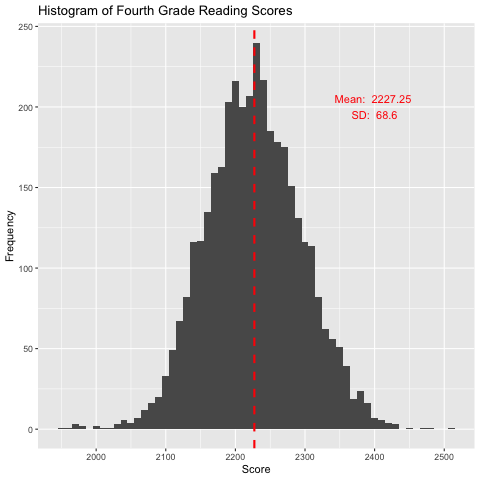

In [11]:
%%R -i df 

# Make a histogram of only fourth grade reading scores
df %>% 
  ggplot(aes(r_fourth_2004)) +
  geom_histogram(binwidth = 10) +
  # remove nulls and plot mean as a vline
  geom_vline(aes(xintercept=mean(r_fourth_2004, na.rm=TRUE)), color="red", linetype="dashed", size=1) +
  # show mean and sd on x=2400, y=200
  annotate("text", x=2400, y=200, label=paste("Mean: ", round(mean(df$r_fourth_2004, na.rm=TRUE), 2), "\nSD: ", round(sd(df$r_fourth_2004, na.rm=TRUE), 2)), color="red") +
  labs(title = "Histogram of Fourth Grade Reading Scores", x = "Score", y = "Frequency")

The 2004 reading scores of `HARRELL BUDD EL` has a z-score of 3.538760. What should we make of that?


In [12]:
# standardize r_fourth_2004 into a z-score in python
df['r_fourth_2004_z'] = (df['r_fourth_2004'] - df['r_fourth_2004'].mean()) / df['r_fourth_2004'].std()
df.head(20)

,CAMPUS,r_third_2004,m_third_2004,r_fourth_2004,m_fourth_2004,r_fifth_2004,m_fifth_2004,r_third_2003,m_third_2003,CNAME,r_fourth_2004_z
2525,131001103,2355.0,2342.0,2509.0,2520.0,NaN,NaN,2424.0,2325.0,SARITA EL,4.107282
1985,101912296,2438.0,2459.0,2480.0,2494.0,2455.0,2538.0,2469.0,2514.0,T H ROGERS EL,3.684535
799,57905115,2160.0,2168.0,2470.0,2394.0,2127.0,2209.0,2140.0,2081.0,HARRELL BUDD EL,3.538760
2916,180901101,2363.0,2385.0,2448.0,2397.0,2169.0,2126.0,2294.0,2164.0,MIMI FARLEY ELE,3.218055
1236,68901118,2454.0,2373.0,2432.0,2444.0,2426.0,2482.0,2431.0,2359.0,EL MAGNET AT RE,2.984815
962,57909122,2392.0,2404.0,2430.0,2431.0,2463.0,2479.0,2386.0,2324.0,WALNUT GLEN ACA,2.955660
1089,57916123,2409.0,2354.0,2426.0,2438.0,2387.0,2369.0,2426.0,2355.0,PRAIRIE CREEK E,2.897350
1011,57911102,2447.0,2434.0,2425.0,2459.0,NaN,NaN,2446.0,2398.0,BRADFIELD ELEME,2.882772
1094,57916128,2402.0,2339.0,2425.0,2416.0,2476.0,2479.0,2402.0,2338.0,BRENTFIELD EL,2.882772
3045,199901110,2374.0,2417.0,2419.0,2399.0,2436.0,2503.0,2447.0,2443.0,GRACE HARTMAN E,2.795307


Let's take a quick look at the overall distributions just to know what to expect as we compare across years

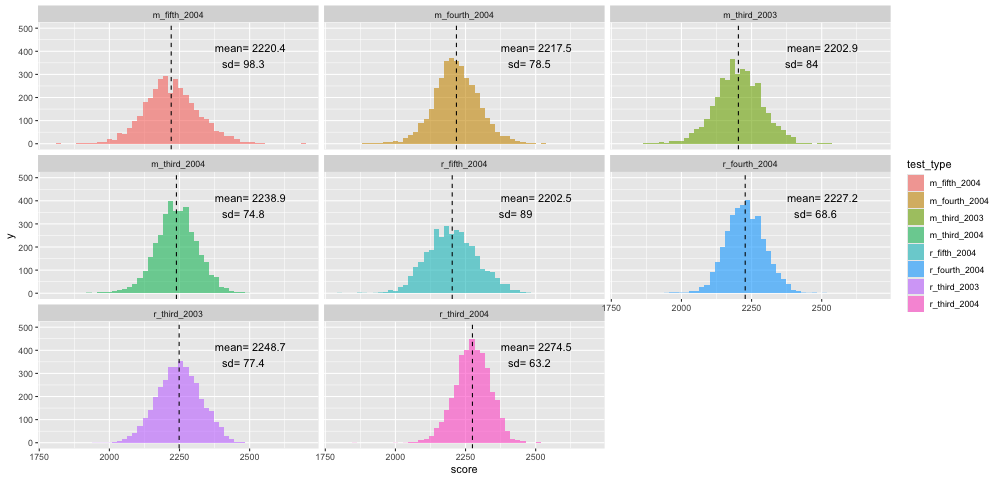

In [13]:
%%R -i df_long -w 1000

ggplot(df_long) + 
    aes(x=score, fill=test_type) +
    geom_histogram(alpha=0.6, bins=50, position='identity') + 
    facet_wrap(~test_type) +
    # plot the mean of each facet as a vline
    geom_vline(data=group_by(df_long, test_type) %>% summarise(mean_score=mean(score)), aes(xintercept=mean_score), color='black', linetype='dashed') + 
    # display the mean as a label
    geom_text (data=group_by(df_long, test_type) %>% summarise(mean_score=mean(score)), aes(x=2250, y=500, label=paste("mean=", round(mean_score, 1))), hjust=-.5, vjust=3, color='black') +
    # display stdev as label
    geom_text (data=group_by(df_long, test_type) %>% summarise(sd_score=sd(score)), aes(x=2250, y=500, label=paste("sd=", round(sd_score, 1))), hjust=-1, vjust=5, color='black') 

**Observations**
- In third grade, students performed better in both reading and math in 2004 compared to 2003
- Fifth grade in 2004 performed worse than fourth and third grade, the stdev was 

# Linear Regressions

👉 Make a scatter plot of third grade reading scores in 2003 vs fourth grade reading scores in 2004. This is theoretically the same(-ish) cohort. Remember, we're interested in **explaining the variance in 2004 fourth grade reading scores**, so we'll keep that as the y.

**How much do we expect third grade reading scores in 2003 to explain fourth grade reading scores in 2003?**

In [14]:
%%R -i df

# Filter out na values
print(paste(nrow(df), "rows before filtering out na values"))
df_filtered <- df %>% filter(!is.na(r_third_2003), !is.na(r_fourth_2004))
print(paste(nrow(df_filtered), "rows after filtering out na values"))

[1] "4284 rows before filtering out na values"
[1] "3501 rows after filtering out na values"


`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



Loading required package: ggrepel


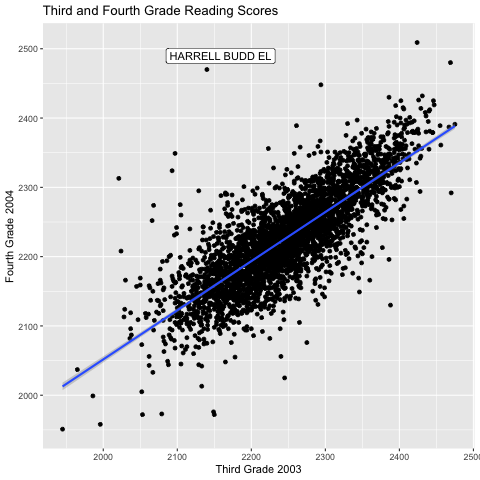

In [31]:
%%R -i df 

require ('ggrepel')
library(ggrepel) 

# Make a scatterplot of reading scores from 2004 vs 2003 
# note: we use third grade in 2003 and fourth grade in 2004
#       to theoretically track the same(ish) students
df_filtered %>% 
  ggplot(aes(r_third_2003, r_fourth_2004)) +
  geom_point() +
  # Display label for HARRELL BUDD EL
  geom_label_repel(aes(label=CNAME), box.padding=0.35, data=filter(df_filtered, CNAME=="HARRELL BUDD EL")) +
  geom_smooth(method = "lm") + 
  labs(title = "Third and Fourth Grade Reading Scores", x = "Third Grade 2003", y = "Fourth Grade 2004")


### How well do last year's third grade reading scores explain this year's foruth grade reading scores?

In [25]:
%%R 

model <- lm(r_fourth_2004 ~ r_third_2003, data=df_filtered)
summary(model)


Call:
lm(formula = r_fourth_2004 ~ r_third_2003, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-200.32  -23.78    0.70   24.15  319.17 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.327e+02  1.994e+01   31.74   <2e-16 ***
r_third_2003 7.094e-01  8.861e-03   80.06   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 40.91 on 3499 degrees of freedom
Multiple R-squared:  0.6469,	Adjusted R-squared:  0.6468 
F-statistic:  6410 on 1 and 3499 DF,  p-value: < 2.2e-16



### How much does `HARRELL BUDD EL` deviate from the model?

In [26]:
%%R -o df_filtered

df_filtered <- df_filtered %>% 
  mutate(
    predicted = predict(model), # Calculate the predicted values
    residuals = residuals(model), # Calculate the residuals
    standardized_residuals = rstandard(model) # Calculate the standardized residuals (z-scores of residuals
  ) %>% 
  arrange(desc(standardized_residuals)) # sort by standardized residuals

df_filtered %>% select(CNAME, r_third_2003, r_fourth_2004, predicted, standardized_residuals) %>% head(20)

               CNAME r_third_2003 r_fourth_2004 predicted
799  HARRELL BUDD EL         2140          2470  2150.828
2426 TEKOA ACADEMY O         2021          2313  2066.409
105  HIGGS/CARTER/KI         2097          2349  2120.324
1873  HENDERSON N EL         2093          2324  2117.486
2916 MIMI FARLEY ELE         2294          2448  2260.077
747  PINNACLE SCHOOL         2068          2274  2099.751
2525       SARITA EL         2424          2509  2352.301
1662  CHILDREN FIRST         2066          2252  2098.332
1195 PRAIRIE VIEW EL         2261          2389  2236.667
859  WILLIAM B MILLE         2129          2295  2143.025
1776 LAKEWOOD ELEMEN         2104          2275  2125.290
363        DEKALB EL         2223          2356  2209.709
701    SIDNEY SCHOOL         2024          2208  2068.537
1814      BASTIAN EL         2105          2260  2125.999
2163  HARTLEY SCHOOL         2159          2288  2164.307
2435          LEE EL         2165          2292  2168.564
1933        SC

# Do we see suspicious activity in the math scores too?

Let's do the same analysis for the math scores. 

👉 Make a scatter plot of third grade math scores in 2003 vs fourth grade math scores in 2004. This is theoretically the same(-ish) cohort. 

Remember, we're interested in **explaining the variance in 2004 fourth grade math scores** now, so we'll keep that as the y.

In [29]:
%%R -i df 

# Filter out any data points that have na for m_third_2003 or m_fourth_2004
print(paste(nrow(df), "rows before filtering out na values"))
df_filtered <- df %>% filter(!is.na(m_third_2003), !is.na(m_fourth_2004))
print(paste(nrow(df_filtered), "rows after filtering out na values"))

[1] "4284 rows before filtering out na values"
[1] "3501 rows after filtering out na values"


`geom_smooth()` using formula = 'y ~ x'


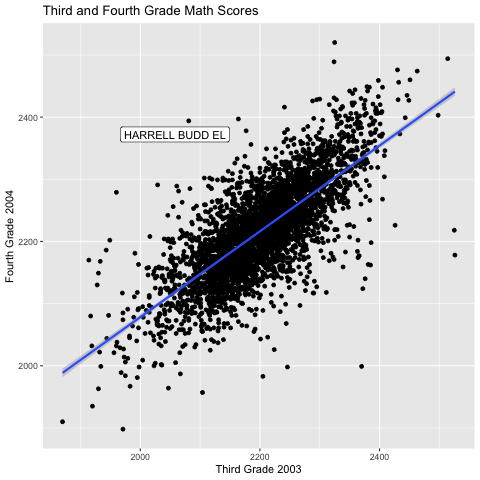

In [32]:
%%R -i df
# Make a scatterplot of math scores from 2004 vs 2003 
# note: we use third grade in 2003 and fourth grade in 2004
#       to theoretically track the same(ish) students
library (ggrepel)
df_filtered %>% 
  ggplot(aes(m_third_2003, m_fourth_2004)) +
  geom_point() +
  # Display label for HARRELL BUDD EL
  geom_label_repel(aes(label=CNAME), box.padding=0.35, data=filter(df_filtered, CNAME=="HARRELL BUDD EL")) +
  geom_smooth(method = "lm") + 
  labs(title = "Third and Fourth Grade Math Scores", x = "Third Grade 2003", y = "Fourth Grade 2004")

### How well do last year's third grade math scores explain this year's fourth grade math scores?

In [33]:
%%R 
# 👉 Make a model using `lm` and interpret the results using `summary`.
model <- lm(m_fourth_2004 ~ m_third_2003, data=df_filtered)
summary(model)


Call:
lm(formula = m_fourth_2004 ~ m_third_2003, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-334.47  -31.24    0.39   32.56  259.83 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  699.01661   23.12570   30.23   <2e-16 ***
m_third_2003   0.68964    0.01049   65.74   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 52.41 on 3499 degrees of freedom
Multiple R-squared:  0.5526,	Adjusted R-squared:  0.5525 
F-statistic:  4322 on 1 and 3499 DF,  p-value: < 2.2e-16



In [36]:
# 👉 interpret the results here (explain R^2, P-values)
# The p value is very small meaning there is a strong correlation between math results for the same cohort in 2003 and 2004
# The R^2 value is 0.5, which means that there is quite a lot of variance - meaning a lot of schools where the correlation isn't as strong.

### How much does `HARRELL BUDD EL` deviate from the model?

In [40]:
%%R -o df_filtered

# 👉 add the predicted values, the residuals and the standardized residuals onto the dataframe `df_filtered`
# look at the resulting dataframe (sorted by residuals) and interpret what yous see

df_filtered <- df_filtered %>% 
  mutate(
    predicted = predict(model), # Calculate the predicted values
    residuals = residuals(model), # Calculate the residuals
    standardized_residuals = rstandard(model) # Calculate the standardized residuals (z-scores of residuals
  ) %>% 
  arrange(desc(standardized_residuals)) # sort by standardized residuals

df_filtered %>% select(CNAME, m_third_2003, m_fourth_2004, predicted, standardized_residuals) %>% head(20)


               CNAME m_third_2003 m_fourth_2004 predicted
799  HARRELL BUDD EL         2081          2394  2134.167
3787  BRIDGEPORT INT         2222          2192  2050.720
2525       SARITA EL         2325          2520  2302.441
2916 MIMI FARLEY ELE         2164          2397  2191.408
3047 ANITA SCOTT ELE         2180          2197  2098.306
1874        HEROD EL         2235          2276  2301.751
65        HOLLAND EL         2282          2228  2200.373
1527          BAY EL         2313          2324  2244.511
2547       ROXTON EL         2372          2124  2120.374
2785        LAMAR EL         2275          2328  2043.134
1917 PORT HOUSTON EL         2158          2228  2122.443
2990   RIDGECREST EL         2270          2300  2018.997
63         SPARTA EL         2296          2306  2205.890
3275    WESTCREEK EL         2194          2146  2152.098
1805 LORENZO DE ZAVA         2192          2289  2135.547
2113 DELORAS E THOMP         2171          2210  2276.924
1007 SALLYE MO

# What are your next steps?

In [21]:
# 👉 Discuss your next steps w/r/t reporting or statistical data analysis.

# Read the Dallas Morning News article

Don't do this step until you've finished all of the above. See what their next steps were and compare them to what you thought to do.

https://courseworks2.columbia.edu/courses/193326/assignments/1229548